## Focus on hippocampal/MTL responses to stimulation

In [1]:
import numpy as np
import mne
from glob import glob
import pandas as pd
import pylab as plt

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')
from codebase import good_subs, target_dict
from utils import swarmplot_subjects

### Single-window power estimations for population-level analysis
Strategy: Similar to Solomon et al. 2021 (Brain Stim), measure stim vs sham t-stat for ~1 second windows (perhaps +500ms offset from stimulation) and visualize results across the population. Use LMM to analyze for population-level effect.

In [2]:
import pandas as pd
from mne.time_frequency import psd_array_multitaper
from scipy.stats import ttest_ind
from codebase import get_window_power

import warnings
warnings.filterwarnings("ignore")  # using this for a really dumb deprecation warning, nothing dangerous is happening

res = pd.DataFrame() # for storing our outputs

# Set some params
fs = 500 #saved data is all 500Hz sampling rate
freqs = [3, 8]
start_time = 1.1 # in seconds
win_size = 1.0 # in seconds
subtract_baseline = True
baseline_start = 0; baseline_win = 0.45 # for subtracting off baseline power

for sub in list(good_subs.keys()): #loop through subjects
    for sess in good_subs[sub]:  #loop through stim sites/sessions

        # Load the data
        tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # using the -0.5 to 2 second files
        sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')
        elecs = pd.read_pickle('./TMSEEG_data/'+sub+'/'+sub+'_'+sess+'_elecs.pkl')
        
        # Get target electrode/coordinates
        target_channel = target_dict[sub][sess][-1]
        target_xyz = np.array(target_dict[sub][sess][0:3])
        
        ## TMS epochs ##
        psd_tms, freqs_used = get_window_power(tms_dat, fs=fs, start_time=start_time, win_size=win_size, freqs=freqs, n_cpus=n_cpus)  #output is trials x chans, averaging over frequencies
    
        ## Sham epochs ##
        psd_sham, freqs_used = get_window_power(sham_dat, fs=fs, start_time=start_time, win_size=win_size, freqs=freqs, n_cpus=n_cpus)
        
        if subtract_baseline:
            psd_tms_baseline, bs_freqs_used = get_window_power(tms_dat, fs=fs, start_time=baseline_start, win_size=baseline_win, freqs=freqs, n_cpus=n_cpus)
            psd_sham_baseline, _ = get_window_power(sham_dat, fs=fs, start_time=baseline_start, win_size=baseline_win, freqs=freqs, n_cpus=n_cpus)
            
            psd_tms = psd_tms-psd_tms_baseline
            psd_sham = psd_sham-psd_sham_baseline
        
        # Get TMS vs Sham T-statistic
        t, p = ttest_ind(psd_tms, psd_sham, axis=0, equal_var=False)
        
        # Remove saturated electrodes (thresholding the TEPs)
        from codebase import get_saturated_elecs
        sat_elecs = get_saturated_elecs(tms_dat, samples=250, thresh_=2)
        
        for idx in range(len(t)): #loop through electrodes
            elec_dict = dict(elecs.iloc[idx])  # harvest electrode information
            
            # Flag saturated electrodes
            if idx in sat_elecs:
                sat_flag=True
            else:
                sat_flag=False
                
            # Get Euclidean distance to stim site
            elec_xyz = np.array(elecs.iloc[idx][['anatX', 'anatY', 'anatZ']])
            euc_dist = np.linalg.norm(target_xyz-elec_xyz)
            if euc_dist<77.7:
                distance_category = 'close'
            elif (euc_dist>77.7) & (euc_dist<105.11):
                distance_category = 'middle'
            else:
                distance_category = 'far'
            
            mydict = {'subject': sub, 'session': sess, 'elec_idx': idx, 'T': t[idx], 'pval': p[idx], 
                     'powers_tms': psd_tms[:, idx], 'powers_sham': psd_sham[:, idx], 'saturated': sat_flag,
                     'target_channel': target_channel, 'target_x': target_xyz[0], 'target_y': target_xyz[1], 
                     'target_z': target_xyz[2], 'target_distance': euc_dist, 'distance_category': distance_category}
            mydict.update(elec_dict)
            
            # Update the DataFrame
            res = res.append(mydict, ignore_index=True)
    print(sub)

404
405
416
423
429
430
477
483
518
534
538
559
561


#### Remove possible artifactual responses
Despite this being "cleaned" data, some amplifier saturation does occur

In [3]:
# Simplest method: apply a T-value threshold (only expect this in the positive direction)
# res = res[res['T']<5]

# Alternate method: Measure the TEP for each electrode and set a t-value threshold
# This will do a good job capturing the saturated channels (e.g. sub 559, elec 62; sub 561, elec 195)
# However, it will not work for data that has not been de-trended (should fall back on a raw T-stat threshold) 
res = res[res['saturated']==False]

# Yet another method: Ensure that stimulated electrodes are excluded from analysis

# Remove epileptogenic electrodes
res = res[res['Seizure_Exclude']==0]

# Z-score the target distances for linear modeling
from scipy.stats import zscore
res['target_distance'] = zscore(res['target_distance'])

#### Population-level hippocampal response

In [4]:
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset='T')

# Isolate hippocampal responses
hipp_data = res_dropna[(res_dropna['DKT_label'].str.contains('Hipp'))]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}
model = sm.MixedLM.from_formula("T ~ 1", data=hipp_data, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(hipp_data, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3,)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('Hippocampal responses');

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T       
No. Observations: 73      Method:             ML      
No. Groups:       11      Scale:              0.4163  
Min. group size:  2       Log-Likelihood:     -83.3820
Max. group size:  22      Converged:          Yes     
Mean group size:  6.6                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.137    0.174 0.787 0.432 -0.204  0.478
g1 Var        0.359    0.307                          



KeyError: 'target'

Note how subject 416 has a dramatically different hippocampal response between stimulation sessions (parietal) and sites (parietal vs. STG)

#### Population-level MTL response

In [5]:
# What about MTL electrodes?
mtl_filter = (res_dropna['DKT_label'].str.contains('hipp')) | (res_dropna['DKT_label'].str.contains('ento')) | (res_dropna['DKT_label'].str.contains('Hipp'))
mtl_data = res_dropna[mtl_filter]

vcf = {'g1':'0+C(session)'}
model = sm.MixedLM.from_formula("T ~ 1", data=mtl_data, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(mtl_data, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3,)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('MTL responses');

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T        
No. Observations: 115     Method:             ML       
No. Groups:       12      Scale:              0.4560   
Min. group size:  2       Log-Likelihood:     -129.6275
Max. group size:  31      Converged:          Yes      
Mean group size:  9.6                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.013     0.134  0.096  0.923  -0.250   0.276
g1 Var     0.219     0.169                              



KeyError: 'target'

**Now subdivide by stimulation region (with >3 subjects, i.e. STG, Parietal, and DLPFC)**

KeyError: 'target'

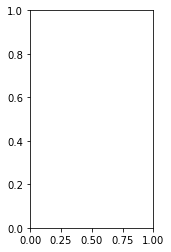

In [6]:
from matplotlib import gridspec

par_mtl = mtl_data[mtl_data['session'].str.contains('Parietal')]
dlpfc_mtl = mtl_data[mtl_data['session'].str.contains('DLPFC')]
stg_mtl = mtl_data[mtl_data['session'].str.contains('STG')]

res_par = sm.MixedLM.from_formula("T ~ 1", data=par_mtl, vc_formula=vcf, groups='subject').fit(reml=False)
res_dlpfc = sm.MixedLM.from_formula("T ~ 1", data=dlpfc_mtl, vc_formula=vcf, groups='subject').fit(reml=False)
res_stg = sm.MixedLM.from_formula("T ~ 1", data=stg_mtl, vc_formula=vcf, groups='subject').fit(reml=False)

# Plot results
plt.figure(figsize=(13, 4));
gs = gridspec.GridSpec(1, 3, width_ratios = [1, 2, 2.2])

#STG
plt.subplot(gs[0])
data_toplot, sub_toplot = swarmplot_subjects(stg_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkred')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkred', boxprops=dict(alpha=.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14); plt.ylabel('Hippocampal Response (T)', fontsize=12)
plt.ylim(-2.7, 2.7)
plt.title('STG Stimulation\n T: '+str(np.round(res_stg.tvalues[0], 3))+', p: '+str(np.round(res_stg.pvalues[0], 3)), fontsize=14);
plt.xticks(fontsize=12)

#Parietal
plt.subplot(gs[1])
data_toplot, sub_toplot = swarmplot_subjects(par_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkblue')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkblue', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.ylim(-2.7, 2.7)
plt.title('Parietal Stimulation, T: '+str(np.round(res_par.tvalues[0], 3))+', p: '+str(np.round(res_par.pvalues[0], 3)), fontsize=14);
plt.xticks(fontsize=12); plt.xlabel('Subject', fontsize=12)

#DLPFC
plt.subplot(gs[2])
data_toplot, sub_toplot = swarmplot_subjects(dlpfc_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkgreen')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkgreen', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.ylim(-2.7, 2.7)
plt.title('DLPFC Stimulation, T: '+str(np.round(res_dlpfc.tvalues[0], 3))+', p: '+str(np.round(res_dlpfc.pvalues[0], 3)), fontsize=14);
plt.xticks(fontsize=12)
plt.tight_layout()
#plt.savefig('./TMSEEG_plots/LMM_hippocampal_theta_1.1_2.1sec.pdf')

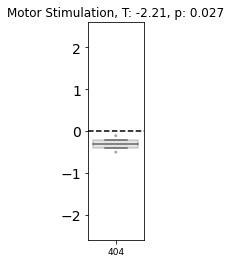

In [91]:
# For curiosity, take a look at motor stimulation
motor_mtl = mtl_data[mtl_data['session'].str.contains('Motor')]
res_motor = sm.MixedLM.from_formula("T ~ 1", data=motor_mtl, vc_formula=vcf, groups='subject').fit(reml=False)

plt.figure(figsize=(1, 4))
data_toplot, sub_toplot = swarmplot_subjects(motor_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkgray')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkgray', boxprops=dict(alpha=.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.ylim(-2.6, 2.6)
plt.title('Motor Stimulation, T: '+str(np.round(res_motor.tvalues[0], 3))+', p: '+str(np.round(res_motor.pvalues[0], 3)));